# Data Load & Cleansing

In [1]:
# load package
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
# load data
accepted_raw = pd.read_csv('../Fez/accepted_2007_to_2018Q4.csv', low_memory=False)
print(accepted_raw.shape)

# save description for NLP (test)
#accepted_raw[['id', 'loan_status', 'desc']].to_csv('./data/desc.csv', index=False)

(2260701, 151)


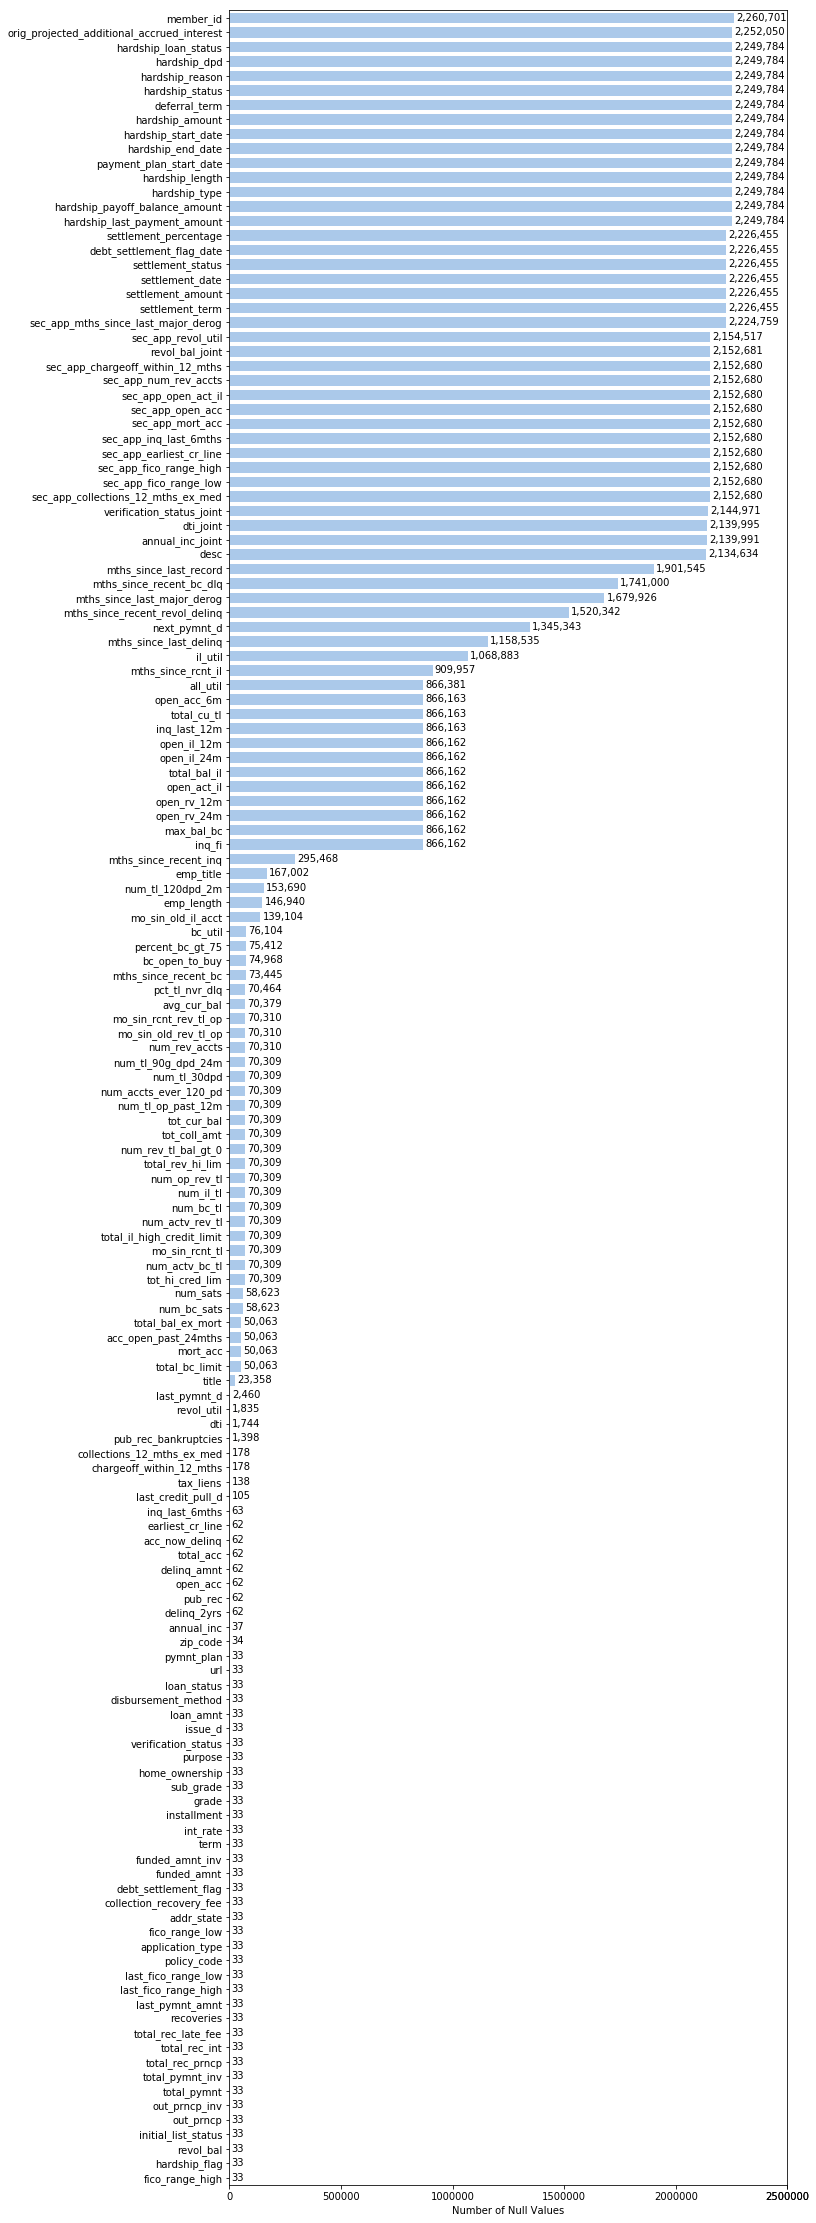

In [5]:
# check null count & visualization
null_x = []
null_y = []

col_null_cnt = accepted_raw.isnull().sum().sort_values(ascending=False)
for k, v in col_null_cnt.iteritems():
    if v > 0:
        null_x = null_x + [k]
        null_y = null_y + [v]

plt.figure(figsize=(10, 40))
sns.set_color_codes('pastel')
sns.barplot(x = null_y, y = null_x, label = 'Count', color = 'b', edgecolor = 'w')
plt.xticks(list(plt.xticks()[0]) + [2500000])
plt.xlabel("Number of Null Values")

for x, y in zip(range(0, len(null_y)), null_y):
    plt.text(y + 10000, x + 0.2, format(y, ',d'))

plt.show()

In [4]:
# drop useless column
accepted = accepted_raw.drop(['member_id', 'id', 'desc', 'url'], axis=1)

# remove wrong parsed rows (33 rows)
accepted = accepted[~accepted['grade'].isnull()]

# convert date type (issue_d)
accepted = accepted.assign(issue_d=pd.to_datetime(accepted['issue_d'], format='%b-%Y'))

# convert lower case
accepted['emp_title'] = accepted['emp_title'].str.lower()
accepted['title'] = accepted['title'].str.lower()

# drop missing column (>= 50%)
# related to hardship, settlement, secondary applicant
drop_cols = []
col_null_cnt = accepted.isnull().sum()
for k, v in col_null_cnt.iteritems():
    if v >= (len(accepted) / 2):
        drop_cols = drop_cols + [k]

print('drop missing column (>= 50%): ' + str(len(drop_cols)))
print(drop_cols)
print()

accepted = accepted.drop(drop_cols, axis=1)

# imputation
accepted['title'] = accepted['title'].replace(np.NaN, 'unknown')
accepted['emp_title'] = accepted['emp_title'].replace(np.NaN, 'unknown')
accepted['emp_length'] = pd.to_numeric(accepted['emp_length'].str.replace(' years|year|\+', '').str.replace('< 1', '0'))
accepted['emp_length'] = accepted['emp_length'] + 1 # shift range
accepted['emp_length'] = accepted['emp_length'].replace(np.NaN, 0) # minimum new value

# imputation (1 record)
accepted['zip_code'] = accepted['zip_code'].replace(np.NaN, '35004') # state: AL
accepted['inq_last_6mths'] = accepted['inq_last_6mths'].replace(np.NaN, 0)
accepted['num_rev_accts'] = accepted['num_rev_accts'].replace(np.NaN, 3.0)

# imputation from team's decision
drop_cols = ['out_prncp', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'funded_amnt',
             'funded_amnt_inv', 'num_actv_rev_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0']

print("drop from team's decision: " + str(len(drop_cols)))
print(drop_cols)

accepted = accepted.drop(drop_cols, axis=1)

drop missing column (>= 50%): 42
['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement

In [5]:
# imputation (IterativeImputer)
target_col = []
drop_cols = []

col_null_cnt = accepted.isnull().sum()
for k, v in col_null_cnt.iteritems():
    if v > 0:
        if accepted[k].dtype == 'float64':
            target_col = target_col + [k]
        else:
            drop_cols = drop_cols + [k]

accepted = accepted.drop(drop_cols, axis=1) # drop non numeric column
print('drop non numeric column (date): ' + str(len(drop_cols)))
print(drop_cols)
print()

print('target columns for imputation: ' + str(len(target_col)))
print(target_col)
print()

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(accepted[target_col])
print(imp)

imputed = imp.transform(accepted[target_col])
accepted[target_col] = imputed

drop non numeric column (date): 3
['earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

target columns for imputation: 56
['annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptc

In [2]:
# save imputed dataframe
# accepted.to_csv('./data/accepted_imputed.csv', index=False)

# load dataframe
accepted = pd.read_csv('./data/accepted_imputed.csv', low_memory=False)

In [11]:
pd.set_option('display.max_columns', 200)
accepted.head(5)

loan_amnt        term  int_rate  installment grade sub_grade  \
0     3600.0   36 months     13.99       123.03     C        C4   
1    24700.0   36 months     11.99       820.28     C        C1   
2    20000.0   60 months     10.78       432.66     B        B4   
3    35000.0   60 months     14.85       829.90     C        C5   
4    10400.0   60 months     22.45       289.91     F        F1   

                     emp_title  emp_length home_ownership  annual_inc  \
0                      leadman        11.0       MORTGAGE     55000.0   
1                     engineer        11.0       MORTGAGE     65000.0   
2                 truck driver        11.0       MORTGAGE     63000.0   
3  information systems officer        11.0       MORTGAGE    110000.0   
4          contract specialist         4.0       MORTGAGE    104433.0   

  verification_status     issue_d loan_status pymnt_plan             purpose  \
0        Not Verified  2015-12-01  Fully Paid          n  debt_consolidation   
1        Not Verified  2015-12-01  Fully Paid          n      small_business   
2        Not Verified  2015-12-01  Fully Paid          n    home_improvement   
3     Source Verified  2015-12-01     Current          n  debt_consolidation   
4     Source Verified  2015-12-01  Fully Paid          n      major_purchase   

                title zip_code addr_state    dti  delinq_2yrs  fico_range_low  \
0  debt consolidation    190xx         PA   5.91          0.0           675.0   
1            business    577xx         SD  16.06          1.0           715.0   
2             unknown    605xx         IL  10.78          0.0           695.0   
3  debt consolidation    076xx         NJ  17.06          0.0           785.0   
4      major purchase    174xx         PA  25.37          1.0           695.0   

   fico_range_high  inq_last_6mths  open_acc  pub_rec  revol_bal  revol_util  \
0            679.0             1.0       7.0      0.0     2765.0        29.7   
1            719.0             4.0      22.0      0.0    21470.0        19.2   
2            699.0             0.0       6.0      0.0     7869.0        56.2   
3            789.0             0.0      13.0      0.0     7802.0        11.6   
4            699.0             3.0      12.0      0.0    21929.0        64.5   

   total_acc initial_list_status   total_pymnt  total_rec_int  \
0       13.0                   w   4421.723917         821.72   
1       38.0                   w  25679.660000         979.66   
2       18.0                   w  22705.924294        2705.92   
3       17.0                   w  31464.010000       12361.66   
4       35.0                   w  11740.500000        1340.50   

   total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_amnt  \
0                 0.0         0.0                      0.0           122.67   
1                 0.0         0.0                      0.0           926.35   
2                 0.0         0.0                      0.0         15813.30   
3                 0.0         0.0                      0.0           829.90   
4                 0.0         0.0                      0.0         10128.96   

   last_fico_range_high  last_fico_range_low  collections_12_mths_ex_med  \
0                 564.0                560.0                         0.0   
1                 699.0                695.0                         0.0   
2                 704.0                700.0                         0.0   
3                 679.0                675.0                         0.0   
4                 704.0                700.0                         0.0   

   policy_code application_type  acc_now_delinq  tot_coll_amt  tot_cur_bal  \
0          1.0       Individual             0.0         722.0     144904.0   
1          1.0       Individual             0.0           0.0     204396.0   
2          1.0        Joint App             0.0           0.0     189699.0   
3          1.0       Individual             0.0           0.0     301500.0   

In [8]:
accepted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2260668 entries, 0 to 2260698
Data columns (total 91 columns):
loan_amnt                     float64
term                          object
int_rate                      float64
installment                   float64
grade                         object
sub_grade                     object
emp_title                     object
emp_length                    float64
home_ownership                object
annual_inc                    float64
verification_status           object
issue_d                       datetime64[ns]
loan_status                   object
pymnt_plan                    object
purpose                       object
title                         object
zip_code                      object
addr_state                    object
dti                           float64
delinq_2yrs                   float64
fico_range_low                float64
fico_range_high               float64
inq_last_6mths                float64
open_acc          

In [9]:
accepted.describe()

loan_amnt      int_rate   installment    emp_length    annual_inc  \
count  2.260668e+06  2.260668e+06  2.260668e+06  2.260668e+06  2.260668e+06   
mean   1.504693e+04  1.309283e+01  4.458068e+02  6.480933e+00  7.799246e+04   
std    9.190245e+03  4.832138e+00  2.671735e+02  3.982435e+00  1.126961e+05   
min    5.000000e+02  5.310000e+00  4.930000e+00  0.000000e+00  0.000000e+00   
25%    8.000000e+03  9.490000e+00  2.516500e+02  3.000000e+00  4.600000e+04   
50%    1.290000e+04  1.262000e+01  3.779900e+02  6.000000e+00  6.500000e+04   
75%    2.000000e+04  1.599000e+01  5.933200e+02  1.100000e+01  9.300000e+04   
max    4.000000e+04  3.099000e+01  1.719830e+03  1.100000e+01  1.100000e+08   

                dti   delinq_2yrs  fico_range_low  fico_range_high  \
count  2.260668e+06  2.260668e+06    2.260668e+06     2.260668e+06   
mean   1.882355e+01  3.068793e-01    6.985882e+02     7.025884e+02   
std    1.417891e+01  8.672248e-01    3.301038e+01     3.301124e+01   
min   -1.330273e+01  0.000000e+00    6.100000e+02     6.140000e+02   
25%    1.190000e+01  0.000000e+00    6.750000e+02     6.790000e+02   
50%    1.784000e+01  0.000000e+00    6.900000e+02     6.940000e+02   
75%    2.449000e+01  0.000000e+00    7.150000e+02     7.190000e+02   
max    9.990000e+02  5.800000e+01    8.450000e+02     8.500000e+02   

       inq_last_6mths      open_acc       pub_rec     revol_bal    revol_util  \
count    2.260668e+06  2.260668e+06  2.260668e+06  2.260668e+06  2.260668e+06   
mean     5.768277e-01  1.161240e+01  1.975279e-01  1.665846e+04  5.034366e+01   
std      8.859598e-01  5.640825e+00  5.705114e-01  2.294831e+04  2.470908e+01   
min      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -1.652153e+01   
25%      0.000000e+00  8.000000e+00  0.000000e+00  5.950000e+03  3.150000e+01   
50%      0.000000e+00  1.100000e+01  0.000000e+00  1.132400e+04  5.030000e+01   
75%      1.000000e+00  1.400000e+01  0.000000e+00  2.024600e+04  6.940000e+01   
max      3.300000e+01  1.010000e+02  8.600000e+01  2.904836e+06  8.923000e+02   

          total_acc   total_pymnt  total_rec_int  total_rec_late_fee  \
count  2.260668e+06  2.260668e+06   2.260668e+06        2.260668e+06   
mean   2.416255e+01  1.208256e+04   2.431388e+03        1.518453e+00   
std    1.198745e+01  9.901383e+03   2.679738e+03        1.184159e+01   
min    1.000000e+00  0.000000e+00   0.000000e+00       -9.500000e-09   
25%    1.500000e+01  4.546458e+03   7.281875e+02        0.000000e+00   
50%    2.200000e+01  9.329720e+03   1.525940e+03        0.000000e+00   
75%    3.100000e+01  1.694087e+04   3.108062e+03        0.000000e+00   
max    1.760000e+02  6.329688e+04   2.819250e+04        1.484340e+03   

         recoveries  collection_recovery_fee  last_pymnt_amnt  \
count  2.260668e+06             2.260668e+06     2.260668e+06   
mean   1.438791e+02             2.398257e+01     3.429346e+03   
std    7.481640e+02             1.312256e+02     6.018248e+03   
min    0.000000e+00             0.000000e+00     0.000000e+00   
25%    0.000000e+00             0.000000e+00     3.103300e+02   
50%    0.000000e+00             0.000000e+00     6.005700e+02   
75%    0.000000e+00             0.000000e+00     3.743750e+03   
max    3.985955e+04             7.174719e+03     4.219205e+04   

       last_fico_range_high  last_fico_range_low  collections_12_mths_ex_med  \
count          2.260668e+06         2.260668e+06                2.260668e+06   
mean           6.876610e+02         6.755397e+02                1.814593e-02   
std            7.297044e+01         1.110976e+02                1.508084e-01   
min            0.000000e+00         0.000000e+00                0.000000e+00   
25%            6.540000e+02         6.500000e+02                0.000000e+00   
50%            6.990000e+02         6.950000e+02                0.000000e+00   
75%            7.340000e+02         7.300000e+02                0.000000e+00   
max            8.500000e+02         8.450000e+02              

# Basic Statistics

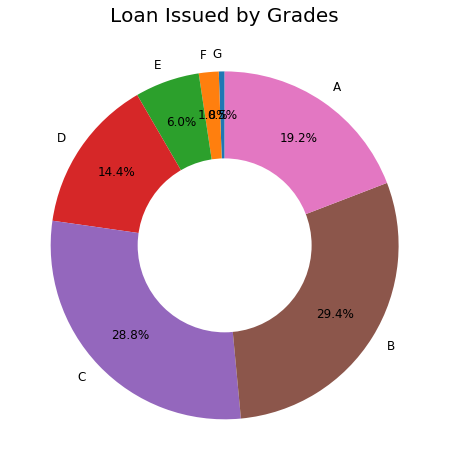

In [114]:
# loan issued grouped by grades
loan_group = accepted['grade'].value_counts()
loan_group_df = pd.DataFrame({'grade':loan_group.index, 'count':loan_group.values})
loan_group_df = loan_group_df.assign(ratio=loan_group_df['count'] / sum(loan_group_df['count']) * 100).sort_values(by='grade', ascending=False)

plt.figure(figsize=(8, 8))
plt.pie(loan_group_df['ratio'], labels=loan_group_df['grade'], autopct='%1.1f%%', startangle=90, pctdistance=0.75, textprops={'fontsize': 12})
plt.title('Loan Issued by Grades', size=20)

centre_circle = plt.Circle((0,0), 0.5, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

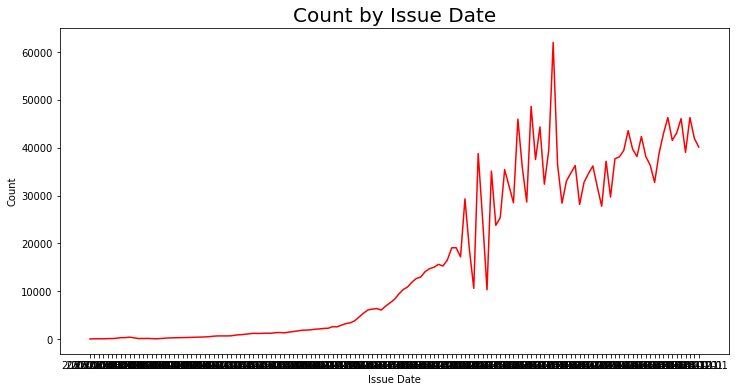

In [3]:
# analysis time series for interest rate (each grade)
count_dt = accepted.groupby(['issue_d']).aggregate({'loan_amnt':'count'})
count_dt = count_dt.reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=count_dt, x='issue_d', y='loan_amnt', color='r').set_title('Count by Issue Date', fontsize=20)

plt.xlabel("Issue Date")
plt.ylabel("Count")

plt.show()

- what happened to near 2016?

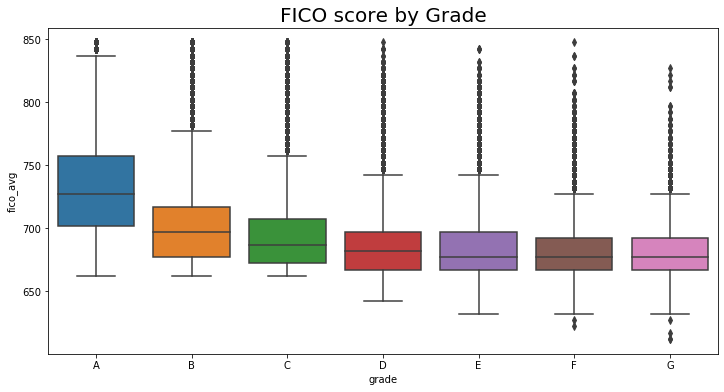

In [22]:
# analysis fico score for grade
fico_avg = (accepted['fico_range_high'] + accepted['fico_range_low']) / 2
grade_agg = accepted.assign(fico_avg=fico_avg).sort_values(by='grade', ascending=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x=grade_agg['grade'], y=grade_agg['fico_avg']).set_title('FICO score by Grade', fontsize=20)
plt.show()

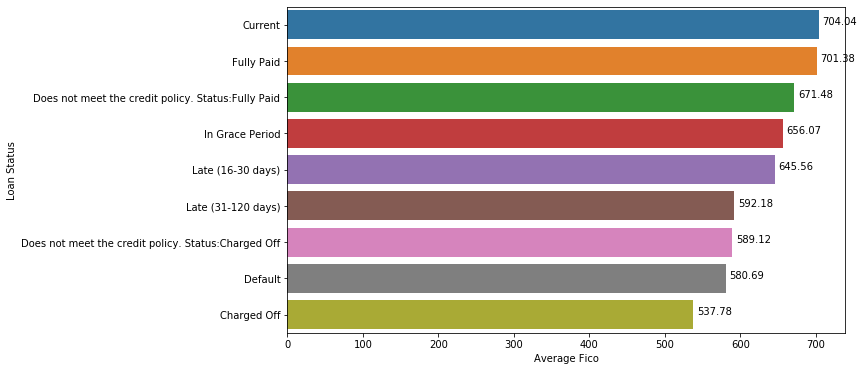

In [15]:
# analysis fico score for grade

fico_avg = (accepted['last_fico_range_high'] + accepted['last_fico_range_low']) / 2
grade_agg = accepted.assign(fico_avg=fico_avg).groupby(['loan_status']).aggregate({'fico_avg':'mean'})
grade_agg = grade_agg[grade_agg['fico_avg'] != 0]
grade_agg = grade_agg.reset_index().sort_values('fico_avg', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='loan_status', x='fico_avg', data=grade_agg)

plt.xlabel("Average Fico")
plt.ylabel("Loan Status")

for x, y in zip(range(0, 9), grade_agg['fico_avg']):
    plt.text(y + 5, x, round(y, 2))

plt.show()

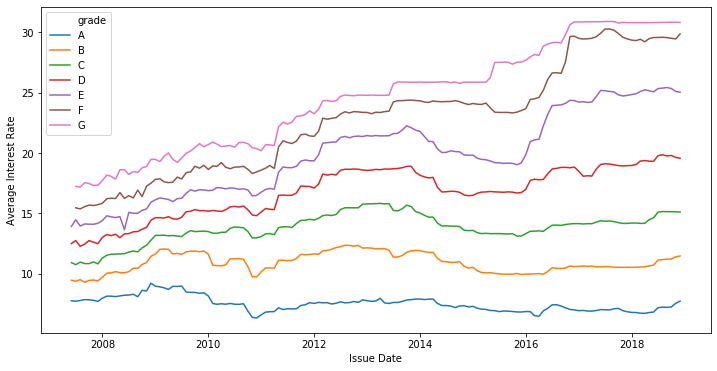

In [13]:
# analysis time series for interest rate (each grade)
int_rate_agg = accepted.groupby(['issue_d','grade']).aggregate({'int_rate':'mean'})
int_rate_agg = int_rate_agg.reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='issue_d', y='int_rate', hue='grade', data=int_rate_agg)

plt.xlabel("Issue Date")
plt.ylabel("Average Interest Rate")
plt.show()

- Low grade(E, F, G) is getting higher interest rate.

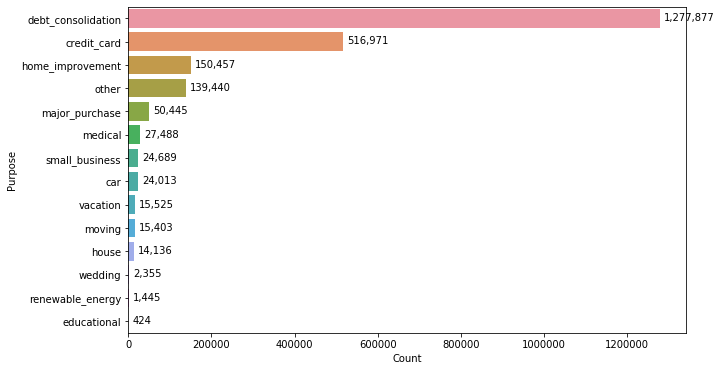

In [14]:
purpose_cnt = accepted['purpose'].value_counts().rename_axis('purpose').to_frame('count').reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(y='purpose', x='count', data=purpose_cnt)

plt.xlabel("Count")
plt.ylabel("Purpose")

for x, y in zip(range(0, 14), purpose_cnt['count']):
    plt.text(y + 10000, x + 0.1, format(y, ',d'))

plt.show()

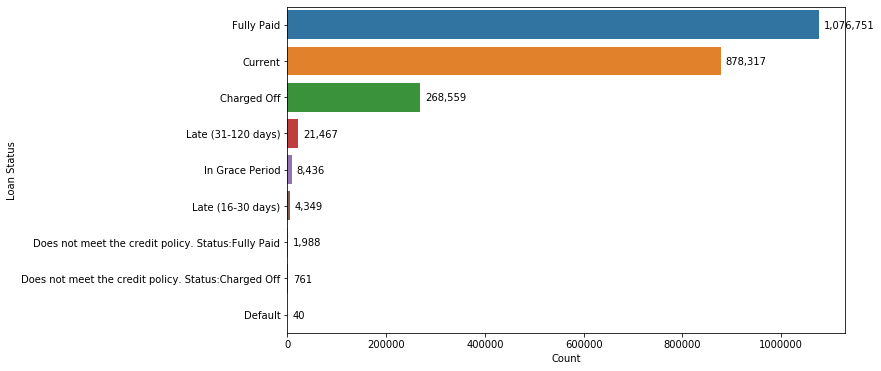

In [15]:
# imbalance (Fully Paid, Current)
status_cnt = accepted['loan_status'].value_counts().rename_axis('status').to_frame('count').reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(y='status', x='count', data=status_cnt)

plt.xlabel("Count")
plt.ylabel("Loan Status")

for x, y in zip(range(0, 14), status_cnt['count']):
    plt.text(y + 10000, x + 0.1, format(y, ',d'))

plt.show()

In [4]:
# total loan amount by each state (map)
import plotly.offline as pyo
import plotly.graph_objects as go

pyo.init_notebook_mode()

state_total_amnt = accepted.groupby(['addr_state']).aggregate({'loan_amnt':['sum']}).reset_index()
state_total_amnt.columns = ['state', 'total_loan']

fig = go.Figure(data=go.Choropleth(
    locations=state_total_amnt['state'],
    z = state_total_amnt['total_loan'],
    locationmode = 'USA-states',
    colorscale = 'Blues',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = 'US Total Loan Amount',
    geo_scope='usa',
)

fig.show()

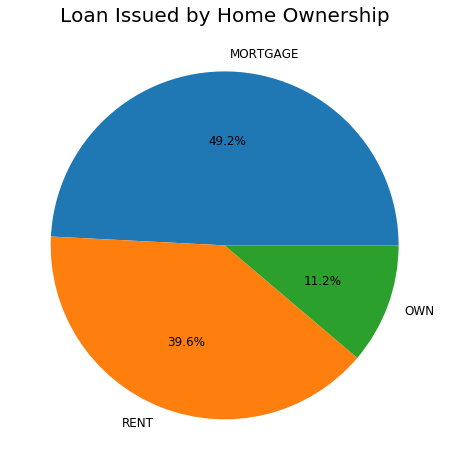

In [113]:
# home ownership
loan_home_ownership = accepted['home_ownership'].value_counts()[:3]
loan_home_ownership_df = pd.DataFrame({'home_ownership':loan_home_ownership.index, 'count':loan_home_ownership.values})
loan_home_ownership_df = loan_home_ownership_df.assign(ratio=loan_home_ownership_df['count'] / sum(loan_home_ownership_df['count']) * 100)

plt.figure(figsize=(8, 8))
plt.pie(loan_home_ownership_df['ratio'], labels=loan_home_ownership_df['home_ownership'], autopct='%1.1f%%', startangle=0, textprops={'fontsize': 12})
plt.title('Loan Issued by Home Ownership', size=20)

plt.show()

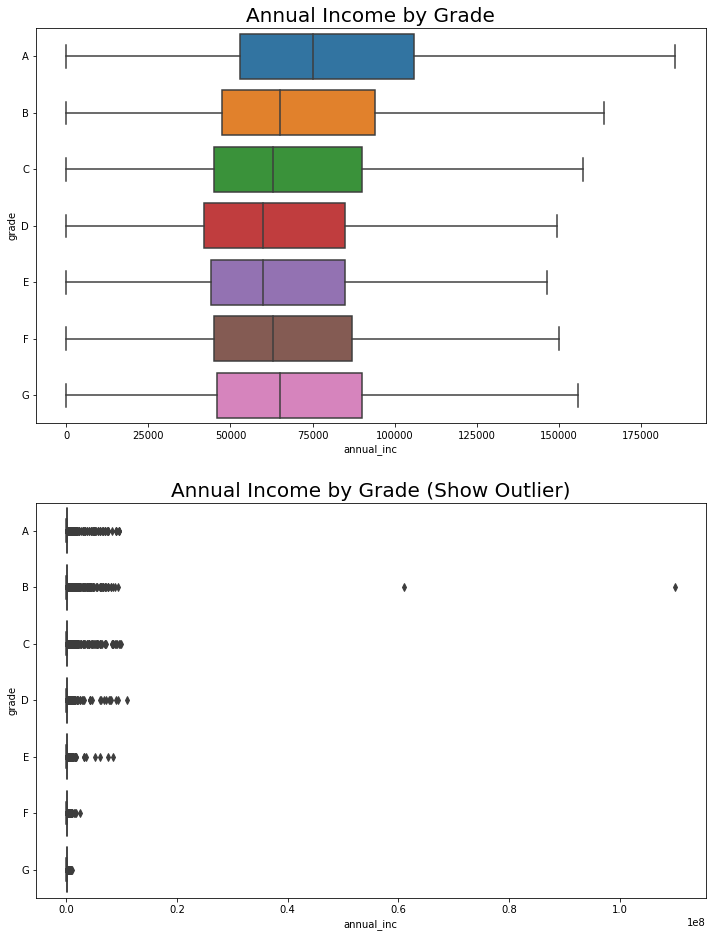

In [88]:
# analysis income for grade
# Because it has big outliers, used (showfliers=False) option to hide that.
fig, axs = plt.subplots(2, figsize=(12, 16))
sns.boxplot(ax=axs[0], x='annual_inc', y='grade', data=accepted.sort_values(by='grade'), orient='h', showfliers=False).set_title('Annual Income by Grade', fontsize=20)
sns.boxplot(ax=axs[1], x='annual_inc', y='grade', data=accepted.sort_values(by='grade'), orient='h').set_title('Annual Income by Grade (Show Outlier)', fontsize=20)

plt.show()

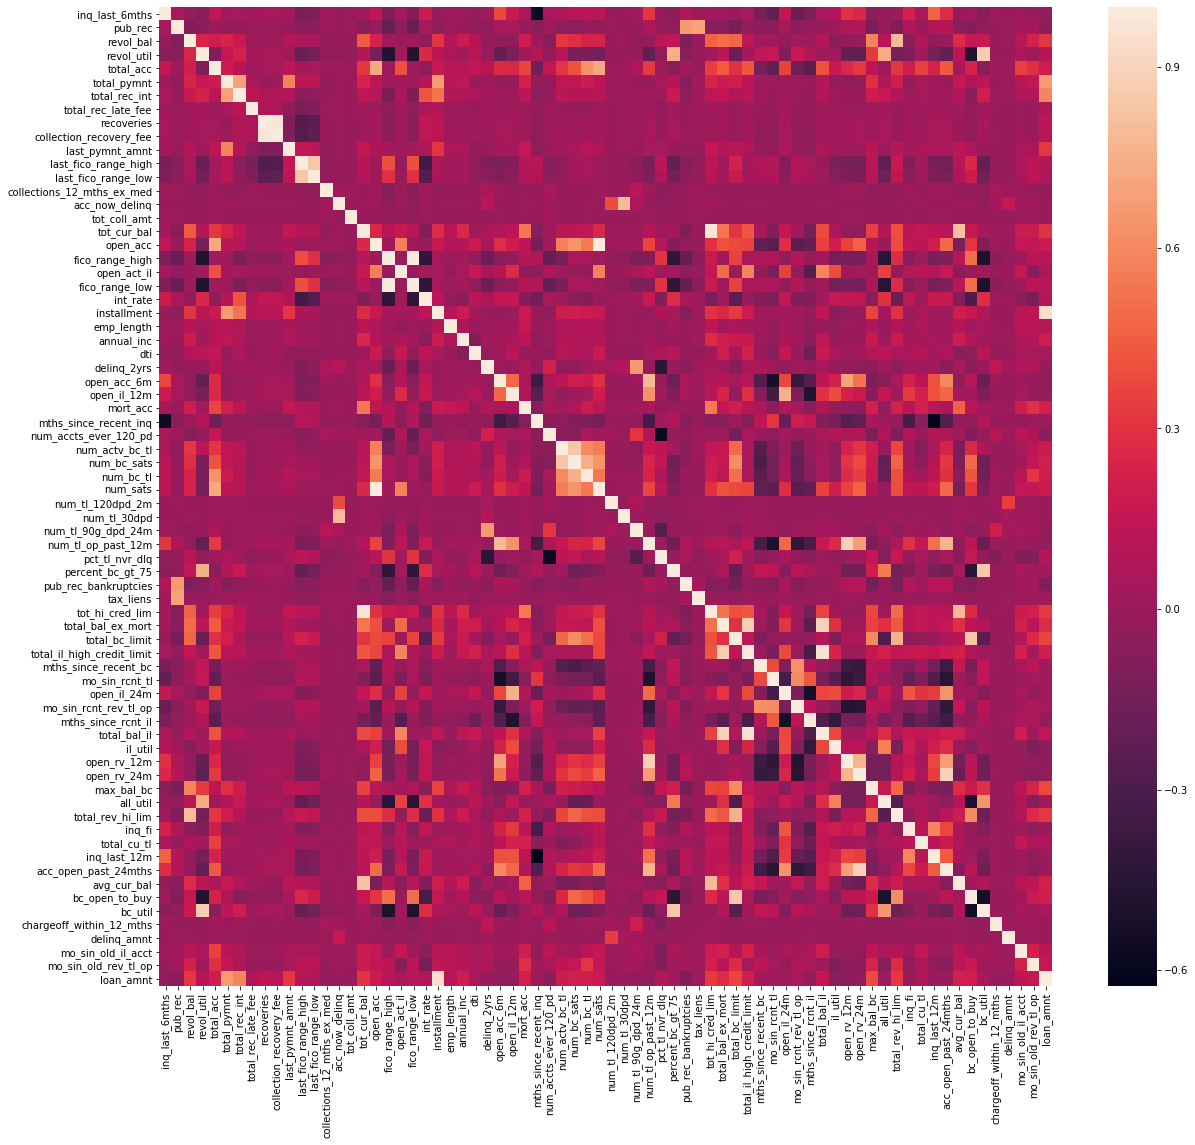

In [17]:
plt.figure(figsize=(20, 18))
sns.heatmap(corr)

# Default Rate Analysis

\begin{equation*}
Default Rate(\%) = \frac{Charged Off + Default}{Fully Paid + Charged Off + Default}
\end{equation*}

In [5]:
# create new data set for Fully Paid and (Charged Off + Default)
accepted_new = accepted[(accepted['loan_status'] == 'Fully Paid') | (accepted['loan_status'] == 'Charged Off') | (accepted['loan_status'] == 'Default')]
accepted_new = accepted_new.assign(paid_flag = np.where(accepted_new['loan_status'].str.contains('Fully Paid'), 1, 0))

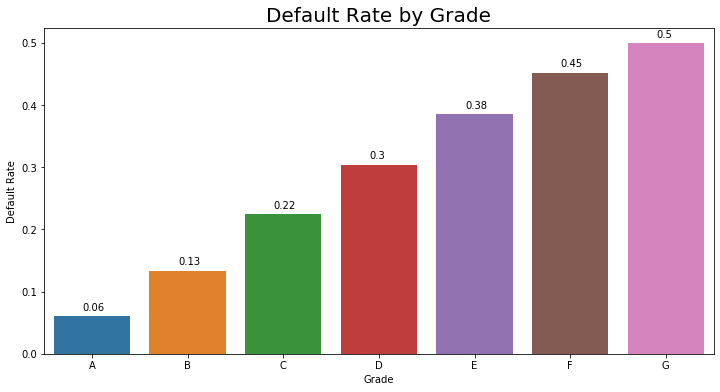

In [19]:
# default rate by grade
default_rate_grade = accepted_new.groupby(['grade']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_grade['paid_flag']['count'] - default_rate_grade['paid_flag']['sum']) / default_rate_grade['paid_flag']['count']
default_rate_grade = default_rate_grade.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.barplot(x='grade', y='default_rate', data=default_rate_grade).set_title('Default Rate by Grade', fontsize=20)

plt.xlabel("Grade")
plt.ylabel("Default Rate")

for x, y in zip(range(0, 7), default_rate_grade['default_rate']):
    plt.text(x - 0.1, y + 0.01, round(y, 2))

plt.show()

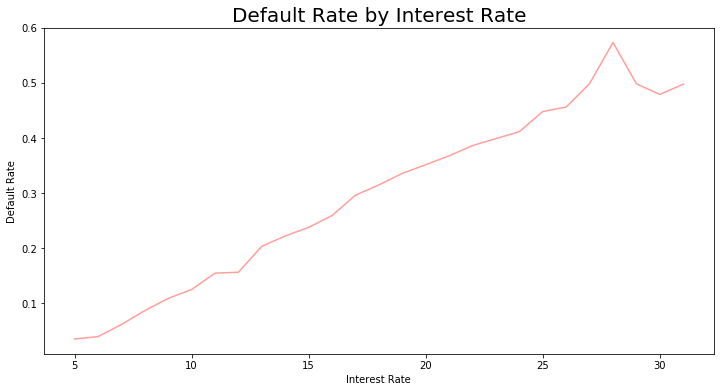

In [20]:
# default rate by interest rate
default_rate_int = accepted_new.assign(int_rate=round(accepted_new['int_rate'])).groupby('int_rate').aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_int['paid_flag']['count'] - default_rate_int['paid_flag']['sum']) / default_rate_int['paid_flag']['count']
default_rate_int = default_rate_int.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.lineplot(x='int_rate', y='default_rate', data=default_rate_int, color='r').set_title('Default Rate by Interest Rate', fontsize=20)

plt.xlabel("Interest Rate")
plt.ylabel("Default Rate")

plt.show()

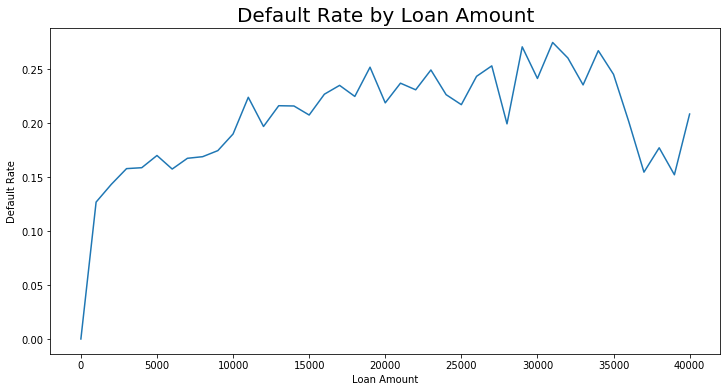

In [21]:
# default rate by Loan Amount
default_rate_loan = accepted_new.assign(loan_amnt=round(accepted_new['loan_amnt'], -3)).groupby('loan_amnt').aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_loan['paid_flag']['count'] - default_rate_loan['paid_flag']['sum']) / default_rate_loan['paid_flag']['count']
default_rate_loan = default_rate_loan.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.lineplot(x='loan_amnt', y='default_rate', data=default_rate_loan).set_title('Default Rate by Loan Amount', fontsize=20)

plt.xlabel("Loan Amount")
plt.ylabel("Default Rate")

plt.show()

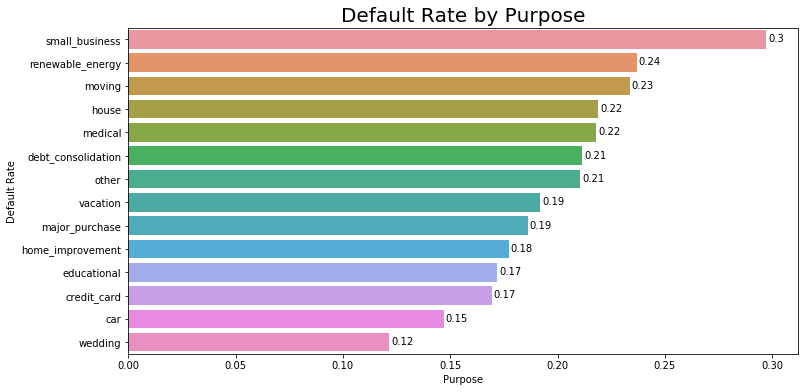

In [23]:
# default rate by purpose
default_rate_purpose = accepted_new.groupby(['purpose']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_purpose['paid_flag']['count'] - default_rate_purpose['paid_flag']['sum']) / default_rate_purpose['paid_flag']['count']
default_rate_purpose = default_rate_purpose.assign(default_rate=default_rate)
default_rate_purpose = default_rate_purpose.sort_values('default_rate', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='default_rate', y='purpose', data=default_rate_purpose).set_title('Default Rate by Purpose', fontsize=20)

plt.xlabel("Purpose")
plt.ylabel("Default Rate")

for x, y in zip(range(0, 14), default_rate_purpose['default_rate']):
    plt.text(y + 0.001, x + 0.1, round(y, 2))

plt.show()

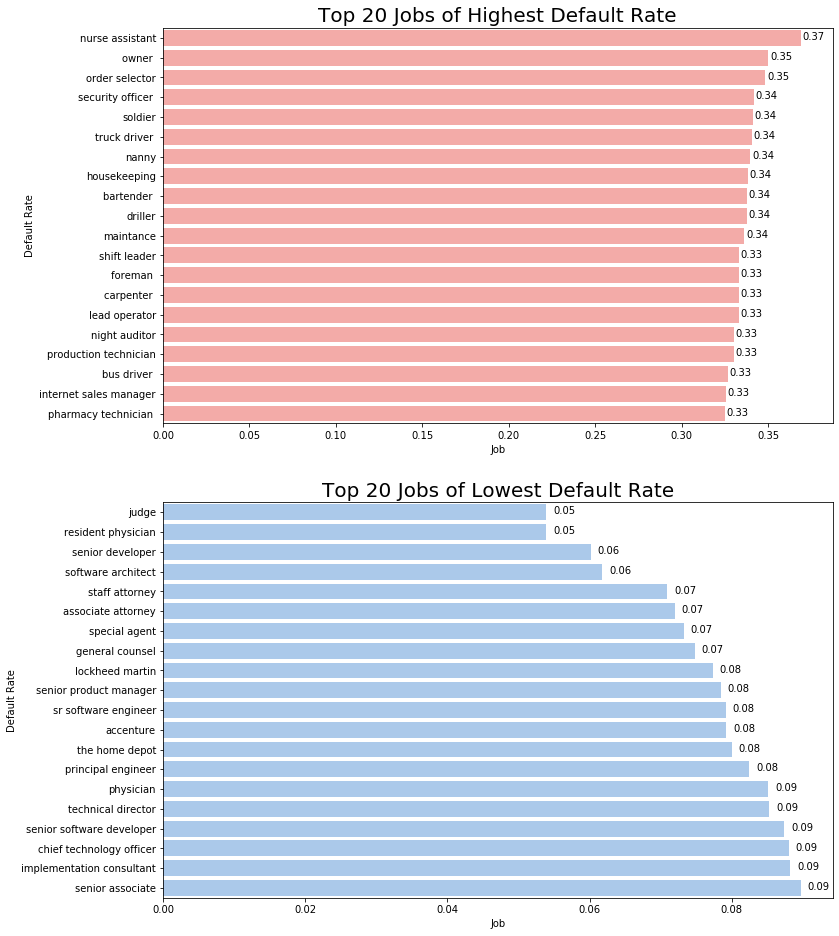

In [24]:
# default rate by job (Highest)
default_rate_emp = accepted_new.groupby(['emp_title']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate_emp.columns = ['emp_title', 'paid_sum', 'paid_count']
default_rate = (default_rate_emp['paid_count'] - default_rate_emp['paid_sum']) / default_rate_emp['paid_count']
default_rate_emp = default_rate_emp.assign(default_rate=default_rate)
default_rate_emp = default_rate_emp[default_rate_emp['paid_count'] > 100]
default_rate_emp_top20 = default_rate_emp.sort_values('default_rate', ascending=False).head(20)

fig, axs = plt.subplots(2, figsize=(12, 16))

sns.barplot(ax=axs[0], x='default_rate', y='emp_title', data=default_rate_emp_top20, color='r').set_title('Top 20 Jobs of Highest Default Rate', fontsize=20)

axs[0].set(xlabel='Job', ylabel='Default Rate')

for x, y in zip(range(0, 20), default_rate_emp_top20['default_rate']):
    axs[0].text(y + 0.001, x + 0.1, round(y, 2))


# default rate by job (Lowest)
default_rate_emp_bottom20 = default_rate_emp.sort_values('default_rate', ascending=True).head(20)

sns.barplot(ax=axs[1], x='default_rate', y='emp_title', data=default_rate_emp_bottom20, color='b').set_title('Top 20 Jobs of Lowest Default Rate', fontsize=20)

axs[1].set(xlabel='Job', ylabel='Default Rate')

for x, y in zip(range(0, 20), default_rate_emp_bottom20['default_rate']):
    axs[1].text(y + 0.001, x + 0.1, round(y, 2))

plt.show()

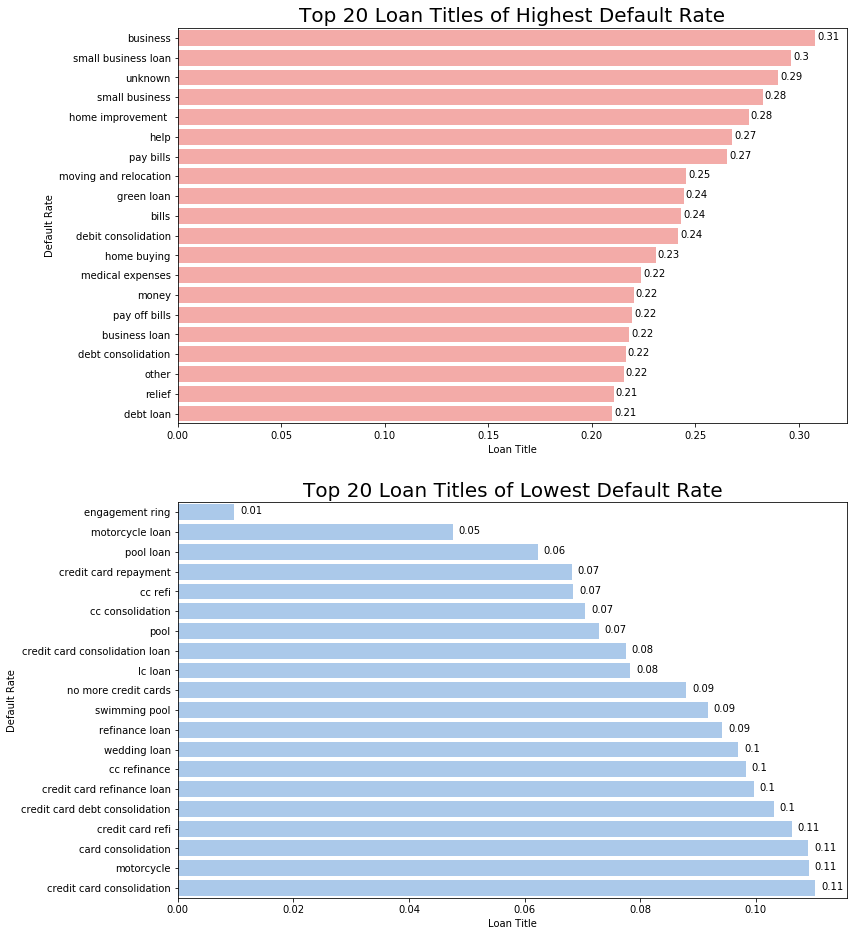

In [25]:
# default rate by loan title (Highest)
default_rate_title = accepted_new.groupby(['title']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate_title.columns = ['title', 'paid_sum', 'paid_count']
default_rate = (default_rate_title['paid_count'] - default_rate_title['paid_sum']) / default_rate_title['paid_count']
default_rate_title = default_rate_title.assign(default_rate=default_rate)
default_rate_title = default_rate_title[default_rate_title['paid_count'] > 100]
default_rate_title_top20 = default_rate_title.sort_values('default_rate', ascending=False).head(20)

fig, axs = plt.subplots(2, figsize=(12, 16))

sns.barplot(ax=axs[0], x='default_rate', y='title', data=default_rate_title_top20, color='r').set_title('Top 20 Loan Titles of Highest Default Rate', fontsize=20)

axs[0].set(xlabel='Loan Title', ylabel='Default Rate')

for x, y in zip(range(0, 20), default_rate_title_top20['default_rate']):
    axs[0].text(y + 0.001, x + 0.1, round(y, 2))


# default rate by loan title (Lowest)
default_rate_title_bottom20 = default_rate_title.sort_values('default_rate', ascending=True).head(20)

sns.barplot(ax=axs[1], x='default_rate', y='title', data=default_rate_title_bottom20, color='b').set_title('Top 20 Loan Titles of Lowest Default Rate', fontsize=20)

axs[1].set(xlabel='Loan Title', ylabel='Default Rate')

for x, y in zip(range(0, 20), default_rate_title_bottom20['default_rate']):
    axs[1].text(y + 0.001, x + 0.1, round(y, 2))

plt.show()

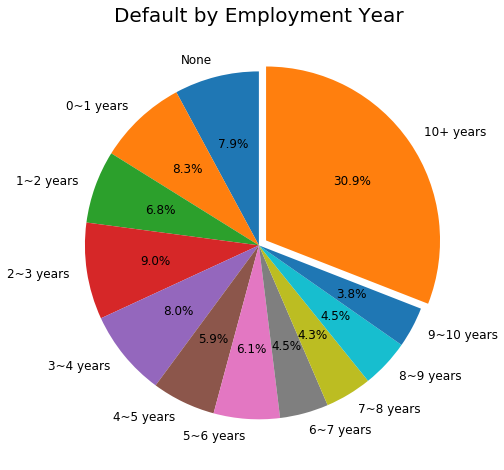

In [26]:
# default rate by employment length
default_rate_emp = accepted_new.groupby('emp_length').aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate_emp.columns = ['emp_length', 'paid', 'count']
default_count = default_rate_emp['count'] - default_rate_emp['paid']
default_rate_emp = default_rate_emp.assign(default=default_count / sum(default_count) * 100)

labels = default_rate_emp['emp_length']
labels = labels.apply(lambda l : str(l - 1).replace('.0', '') + '~' + str(l).replace('.0', '') + ' years')
labels = labels.replace('10~11 years', '10+ years')
labels = labels.replace('-1~0 years', 'None')

explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05)
plt.figure(figsize=(8, 8))
plt.pie(default_rate_emp['default'], explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('Default by Employment Year', size=20)

plt.show()

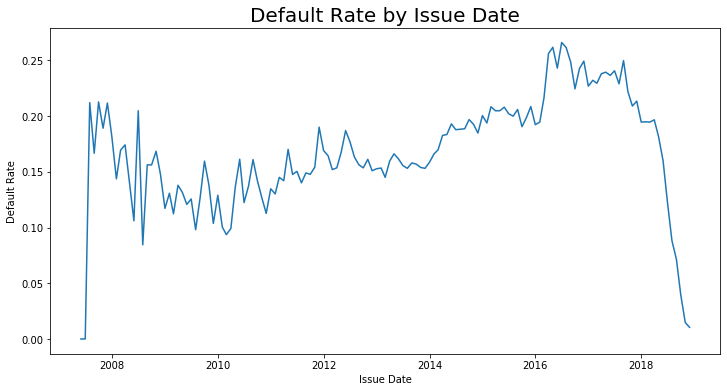

In [27]:
# default rate by Date
default_rate_dt = accepted_new.groupby('issue_d').aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_dt['paid_flag']['count'] - default_rate_dt['paid_flag']['sum']) / default_rate_dt['paid_flag']['count']
default_rate_dt = default_rate_dt.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.lineplot(x='issue_d', y='default_rate', data=default_rate_dt).set_title('Default Rate by Issue Date', fontsize=20)

plt.xlabel("Issue Date")
plt.ylabel("Default Rate")

plt.show()

# Invest Profit Analysis

\begin{equation*}
Profit Rate(\%) = \frac{Total Payment - Loan Amount}{Loan Amount}
\end{equation*}

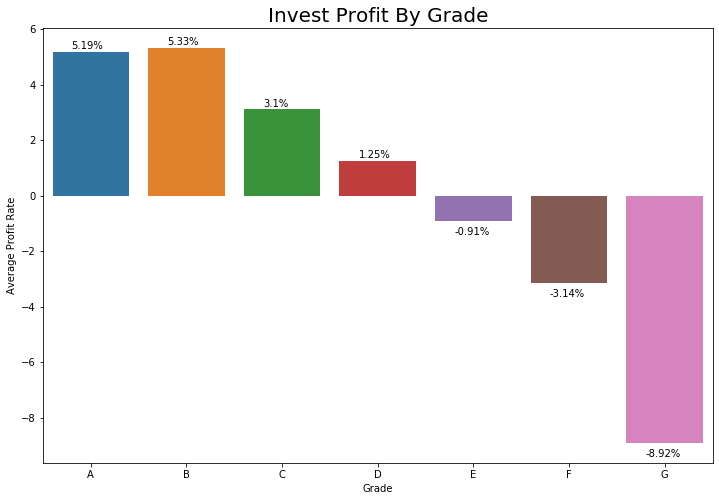

In [29]:
# invest profit by grade
profit_rate = (accepted_new['total_pymnt'] - accepted_new['loan_amnt']) / accepted_new['loan_amnt'] * 100
grade_agg = accepted_new.assign(profit_rate=profit_rate).groupby(['grade']).aggregate({'profit_rate':'mean'})
grade_agg = grade_agg.reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='grade', y='profit_rate', data=grade_agg).set_title('Invest Profit By Grade', fontsize=20)

plt.xlabel("Grade")
plt.ylabel("Average Profit Rate")

for x, y in zip(range(0, 7), grade_agg['profit_rate']):
    if y < 0:
        plt.text(x - 0.2, y - 0.5, str(round(y, 2)) + '%')
    else:
        plt.text(x - 0.2, y + 0.1, str(round(y, 2)) + '%')

plt.show()

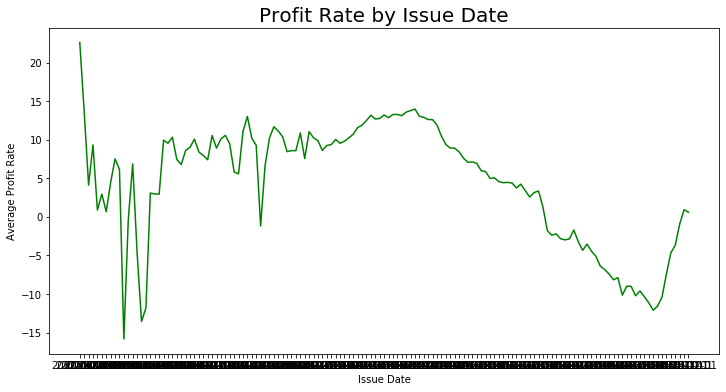

In [6]:
# default rate by Date
profit_rate = (accepted_new['total_pymnt'] - accepted_new['loan_amnt']) / accepted_new['loan_amnt'] * 100
date_agg = accepted_new.assign(profit_rate=profit_rate).groupby(['issue_d']).aggregate({'profit_rate':'mean'})
date_agg = date_agg.reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='issue_d', y='profit_rate', data=date_agg, color='g').set_title('Profit Rate by Issue Date', fontsize=20)

plt.xlabel("Issue Date")
plt.ylabel("Average Profit Rate")

plt.show()